In [22]:
import torchaudio
from torch.utils.data import Dataset, DataLoader
import os
import librosa
from pydub import AudioSegment
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Define Dataset class

In [26]:
class audio_dataset(Dataset):
    def __init__(self, root_directory, labels_file, transform=None):
        self.root_directory = root_directory
        self.labels_file = labels_file
        self.transform = transform
        self.audiofiles = []
        for f in os.listdir(root_directory):
            if f.endswith('.wav'):
                self.audiofiles.append(f)

        self.labels = []
        with open(labels_file, 'r') as file:
            for line in file:
                self.labels.append(int(line.split(",")[6].strip()))

    def __len__(self):
        return len(self.audiofiles)

    def __getitem__(self, idx):
        afile_path = os.path.join(self.root_directory, self.audiofiles[idx])
            
        audio = self._load_audio(afile_path)

        audio = self._pad_or_truncate_audio(audio, target_width=345)
            
        if self.transform:
                audio = self.transform(audio)

        label = int(self.audiofiles[idx].split('-')[1])
            
        return audio, label

    def _load_audio(self, audio_path):
        y, sr = librosa.load(audio_path, sr=None)
        # Computes power spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        # Converts to dB spectrogram
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        return torch.tensor(mel_spectrogram_db).unsqueeze(0).float()

    def _pad_or_truncate_audio(self, audio, target_width):
        _, _, current_width = audio.shape
        
        if current_width < target_width:
            # Pad with zeros on the right if the current width is less than the target width
            padding_amount = target_width - current_width
            audio = F.pad(audio, (0, padding_amount), "constant", 0)
        elif current_width > target_width:
            # Truncate the audio tensor if the current width is greater than the target width
            audio = audio[:, :, :target_width]
    
        return audio

    def visualize_mel_spectrogram(self, idx):
        audio_path = os.path.join(self.root_directory, self.audiofiles[idx])
        y, sr = librosa.load(audio_path, sr=None)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Plot the mel spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel-frequency spectrogram for {self.audiofiles[idx]}')
        plt.tight_layout()
        plt.show()

    def data_shape(self):
        first_sample = self[0]
        audio, _ = first_sample
        return audio.shape


## Dataset initialization

In [27]:
dataset = audio_dataset(root_directory = '/Users/jacksloan/ML_projects/urban_sound_classification/audio_cleaned', labels_file = 'UrbanSound8K.csv')

Data Shape: torch.Size([1, 128, 345])


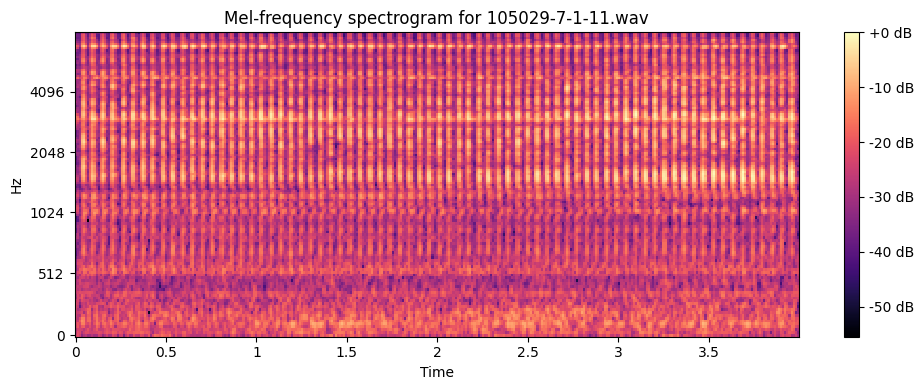

In [31]:
import torch
dshape = dataset.data_shape()
print(f"Data Shape: {dshape}")
dataset.visualize_mel_spectrogram(0)

#### List a few audio files to verify quality and label matches (Only possible w/ raw audio files)

In [7]:
# from IPython.display import Audio, display
# import matplotlib.pyplot as plt

# def visualize_sample(dataset, index, sample_rate=44100):
#     waveform, label = dataset[index]

#     filename = dataset.audiofiles[index]

#     display(Audio(waveform.numpy(), rate=sample_rate))

#     print(f"Label: {label}, Filename: {filename}")

# for i in range(5):
#     visualize_sample(dataset, i)

## Partition Dataset

In [9]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Neural Net architechture

In [10]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding = 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding = 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding = 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding = 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        #Calculated using separate dummy script
        self.linear = nn.Linear(26496, 64)
        self.softmax = nn.Softmax(dim=1)

    def forward (self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions

In [14]:
import torch
from torch import nn
import torch.optim as optim

device = torch.device('cpu')

model = CNN().to(device)

batch_size = 64
learning_rate = 0.001
num_epochs = 10

criterion = nn.CrossEntropyLoss()  # Assuming you have multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        print_every = 10
        if (batch_idx + 1) % print_every == 0:
            num_batches = len(train_loader)
            progress = (batch_idx + 1) / num_batches * 100
            print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{num_batches}], Loss: {running_loss / (batch_idx + 1):.4f}, Progress: {progress:.2f}%")
    
    # Print average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Average Loss: {avg_loss:.4f}")
print('Training complete')

Epoch [1/10], Batch [10/110], Loss: 4.0844, Progress: 9.09%
Epoch [1/10], Batch [20/110], Loss: 4.0787, Progress: 18.18%
Epoch [1/10], Batch [30/110], Loss: 4.0772, Progress: 27.27%
Epoch [1/10], Batch [40/110], Loss: 4.0801, Progress: 36.36%
Epoch [1/10], Batch [50/110], Loss: 4.0761, Progress: 45.45%
Epoch [1/10], Batch [60/110], Loss: 4.0800, Progress: 54.55%
Epoch [1/10], Batch [70/110], Loss: 4.0799, Progress: 63.64%
Epoch [1/10], Batch [80/110], Loss: 4.0794, Progress: 72.73%
Epoch [1/10], Batch [90/110], Loss: 4.0815, Progress: 81.82%
Epoch [1/10], Batch [100/110], Loss: 4.0776, Progress: 90.91%
Epoch [1/10], Batch [110/110], Loss: 4.0795, Progress: 100.00%
Epoch [1/10] Average Loss: 4.0795
Epoch [2/10], Batch [10/110], Loss: 4.0479, Progress: 9.09%


KeyboardInterrupt: 

In [ ]:
def test_model(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return avg_test_loss, accuracy

avg_test_loss, test_accuracy = test_model(model, test_loader, criterion, device)